In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizer, BertConfig
from torch.utils.data import Dataset

/var/folders/g2/l8tf1d856y178ysb622n5k400000gn/T/ipykernel_1717/2809409826.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'mps'
device

'mps'

In [3]:
df_org= pd.read_csv("labelled_bert.csv")

df_org = df_org[df_org['body'].notna()]

df_org = df_org.sample(frac=1.0)

df_org.head()

,message_id,created_at,tag,symbol,sentiment,spamsentiment,body,set
978,557969177,2024-01-16T15:17:00Z,Bullish,ACRS,positive,NaN,$2 plus coming soon??,training
571,534228112,2023-06-30T13:04:06Z,NaN,VTN,spam,neutral,"[15s. delayed] filed form DEFA14A on June 30,...",training
1543,536081060,2023-07-14T20:37:23Z,NaN,MSB,spam,neutral,Mesabi Trust Press Release https://www.confer...,training
416,543261893,2023-09-02T12:59:42Z,NaN,EVBN,spam,negative,Attention! Hedge Funds started their game with...,training
2074,554050170,2023-12-11T13:16:20Z,Bullish,FHTX,spam,positive,"A.I.dvisor made a bullish call on , netting in...",NaN


In [4]:
labels = df_org['sentiment'].unique().tolist()
labels

['positive', 'spam', 'neutral', 'negative']

In [5]:
for key, value in enumerate(labels):
    print(value)

positive
spam
neutral
negative


In [6]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [7]:
label2id

{'positive': 0, 'spam': 1, 'neutral': 2, 'negative': 3}

In [8]:
id2label

{0: 'positive', 1: 'spam', 2: 'neutral', 3: 'negative'}

In [9]:
df_org.head()

,message_id,created_at,tag,symbol,sentiment,spamsentiment,body,set
978,557969177,2024-01-16T15:17:00Z,Bullish,ACRS,positive,NaN,$2 plus coming soon??,training
571,534228112,2023-06-30T13:04:06Z,NaN,VTN,spam,neutral,"[15s. delayed] filed form DEFA14A on June 30,...",training
1543,536081060,2023-07-14T20:37:23Z,NaN,MSB,spam,neutral,Mesabi Trust Press Release https://www.confer...,training
416,543261893,2023-09-02T12:59:42Z,NaN,EVBN,spam,negative,Attention! Hedge Funds started their game with...,training
2074,554050170,2023-12-11T13:16:20Z,Bullish,FHTX,spam,positive,"A.I.dvisor made a bullish call on , netting in...",NaN


In [10]:
df_org["labels"]=df_org.sentiment.map(lambda x: label2id[x])

In [11]:
df_org.head(5)

,message_id,created_at,tag,symbol,sentiment,spamsentiment,body,set,labels
978,557969177,2024-01-16T15:17:00Z,Bullish,ACRS,positive,NaN,$2 plus coming soon??,training,0
571,534228112,2023-06-30T13:04:06Z,NaN,VTN,spam,neutral,"[15s. delayed] filed form DEFA14A on June 30,...",training,1
1543,536081060,2023-07-14T20:37:23Z,NaN,MSB,spam,neutral,Mesabi Trust Press Release https://www.confer...,training,1
416,543261893,2023-09-02T12:59:42Z,NaN,EVBN,spam,negative,Attention! Hedge Funds started their game with...,training,1
2074,554050170,2023-12-11T13:16:20Z,Bullish,FHTX,spam,positive,"A.I.dvisor made a bullish call on , netting in...",NaN,1


<Axes: ylabel='count'>

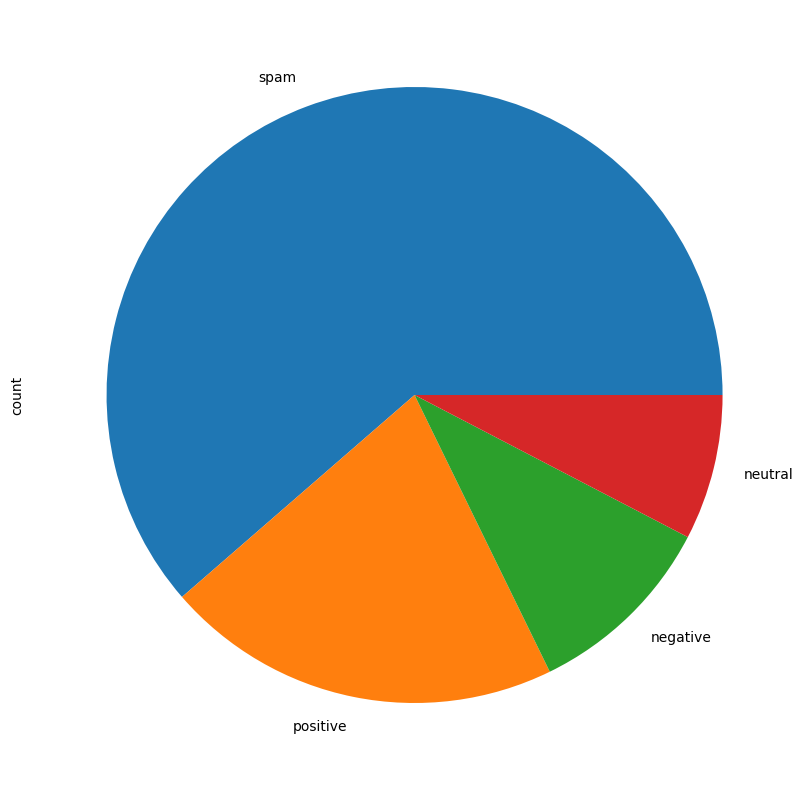

In [12]:
df_org.sentiment.value_counts().plot(kind='pie', figsize=(10,10))

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Splitting df_org


In [15]:
SIZE= df_org.shape[0]

train_texts= list(df_org.body[:SIZE//2])

val_texts=   list(df_org.body[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.body[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [16]:
len(train_texts)


1100

In [17]:
for e in train_texts:
    if type(e)!=str:
        print(e)
        print('not string')

In [18]:
len(train_texts), len(val_texts), len(test_texts)

(1100, 550, 551)

In [19]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [20]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [21]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

## Training with Trainer Class

In [22]:
from transformers import TrainingArguments, Trainer

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [24]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4902Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=5.1,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs-bert',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=False,
    load_best_model_at_end=True
)

In [25]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

In [26]:
trainer.train()

 14%|█▍        | 50/352 [01:24<07:42,  1.53s/it]

{'loss': 1.0011, 'learning_rate': 2.5e-05, 'epoch': 0.72}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
 14%|█▍        | 50/352 [01:36<07:42,  1.53s/it]

{'eval_loss': 0.6446748375892639, 'eval_Accuracy': 0.7490909090909091, 'eval_F1': 0.3767685851318945, 'eval_Precision': 0.3443627450980392, 'eval_Recall': 0.44909555371444354, 'eval_runtime': 11.7807, 'eval_samples_per_second': 46.687, 'eval_steps_per_second': 1.528, 'epoch': 0.72}


 28%|██▊       | 100/352 [02:58<07:12,  1.72s/it]

{'loss': 0.6568, 'learning_rate': 5e-05, 'epoch': 1.45}


                                                 
 28%|██▊       | 100/352 [03:10<07:12,  1.72s/it]

{'eval_loss': 0.5996368527412415, 'eval_Accuracy': 0.7745454545454545, 'eval_F1': 0.4681199953689493, 'eval_Precision': 0.7055574128162719, 'eval_Recall': 0.48905777551179375, 'eval_runtime': 11.5545, 'eval_samples_per_second': 47.601, 'eval_steps_per_second': 1.558, 'epoch': 1.45}


 43%|████▎     | 150/352 [05:04<07:47,  2.32s/it]

{'loss': 0.6053, 'learning_rate': 4.007936507936508e-05, 'epoch': 2.17}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 43%|████▎     | 150/352 [05:16<07:47,  2.32s/it]

{'eval_loss': 0.6100879907608032, 'eval_Accuracy': 0.7672727272727272, 'eval_F1': 0.4260865945648555, 'eval_Precision': 0.4442528735632184, 'eval_Recall': 0.4657161925803185, 'eval_runtime': 12.0583, 'eval_samples_per_second': 45.612, 'eval_steps_per_second': 1.493, 'epoch': 2.17}


 57%|█████▋    | 200/352 [06:59<03:59,  1.57s/it]

{'loss': 0.4945, 'learning_rate': 3.0158730158730158e-05, 'epoch': 2.9}


                                                 
 57%|█████▋    | 200/352 [07:11<03:59,  1.57s/it]

{'eval_loss': 0.6134743690490723, 'eval_Accuracy': 0.78, 'eval_F1': 0.5711408529787351, 'eval_Precision': 0.6101179981374916, 'eval_Recall': 0.5765915587373748, 'eval_runtime': 11.498, 'eval_samples_per_second': 47.834, 'eval_steps_per_second': 1.565, 'epoch': 2.9}


 71%|███████   | 250/352 [08:51<03:32,  2.09s/it]

{'loss': 0.2878, 'learning_rate': 2.023809523809524e-05, 'epoch': 3.62}


                                                 
 71%|███████   | 250/352 [09:02<03:32,  2.09s/it]

{'eval_loss': 0.6361744403839111, 'eval_Accuracy': 0.7945454545454546, 'eval_F1': 0.5842351860927713, 'eval_Precision': 0.6225194388100067, 'eval_Recall': 0.5846812397765173, 'eval_runtime': 11.8098, 'eval_samples_per_second': 46.572, 'eval_steps_per_second': 1.524, 'epoch': 3.62}


 85%|████████▌ | 300/352 [10:21<01:20,  1.55s/it]

{'loss': 0.2094, 'learning_rate': 1.0317460317460318e-05, 'epoch': 4.35}


                                                 
 85%|████████▌ | 300/352 [10:33<01:20,  1.55s/it]

{'eval_loss': 0.6959762573242188, 'eval_Accuracy': 0.7945454545454546, 'eval_F1': 0.6119779536718606, 'eval_Precision': 0.6261657577199272, 'eval_Recall': 0.6093198625303016, 'eval_runtime': 11.53, 'eval_samples_per_second': 47.701, 'eval_steps_per_second': 1.561, 'epoch': 4.35}


 99%|█████████▉| 350/352 [11:54<00:03,  1.56s/it]

{'loss': 0.1571, 'learning_rate': 3.9682539682539683e-07, 'epoch': 5.07}


                                                 
 99%|█████████▉| 350/352 [12:06<00:03,  1.56s/it]

{'eval_loss': 0.72574383020401, 'eval_Accuracy': 0.7981818181818182, 'eval_F1': 0.6129248697023703, 'eval_Precision': 0.6286685989357212, 'eval_Recall': 0.6089476864539002, 'eval_runtime': 11.5385, 'eval_samples_per_second': 47.667, 'eval_steps_per_second': 1.56, 'epoch': 5.07}


100%|██████████| 352/352 [12:09<00:00,  2.07s/it]

{'train_runtime': 729.6736, 'train_samples_per_second': 7.688, 'train_steps_per_second': 0.482, 'train_loss': 0.4853228778070347, 'epoch': 5.1}


TrainOutput(global_step=352, training_loss=0.4853228778070347, metrics={'train_runtime': 729.6736, 'train_samples_per_second': 7.688, 'train_steps_per_second': 0.482, 'train_loss': 0.4853228778070347, 'epoch': 5.1})

In [27]:
train_loss = []
val_loss = []
val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
for e in trainer.state.log_history:
    if 'loss' in e.keys():
        train_loss.append(e['loss'])
    if 'eval_loss' in e.keys():
        val_loss.append(e['eval_loss'])
    if 'eval_Accuracy' in e.keys():
        val_accuracy.append(e['eval_Accuracy'])
    if 'eval_Precision' in e.keys():
        val_precision.append(e['eval_Precision'])
    if 'eval_Recall' in e.keys():
        val_recall.append(e['eval_Recall'])
    if 'eval_F1' in e.keys():
        val_f1.append(e['eval_F1'])

In [28]:
import matplotlib.pyplot as plt

In [29]:
iters = range(50,399,50)
iters = list(iters)

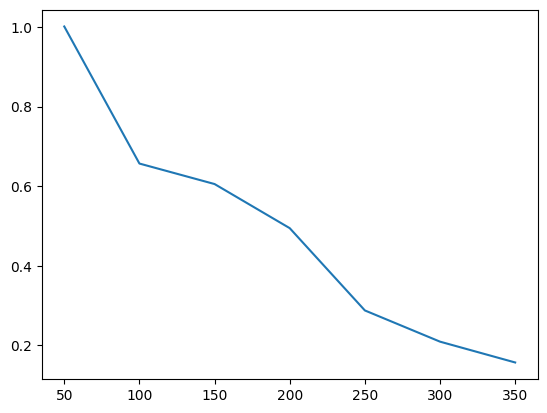

In [30]:
plt.plot(iters,train_loss[:len(iters)])

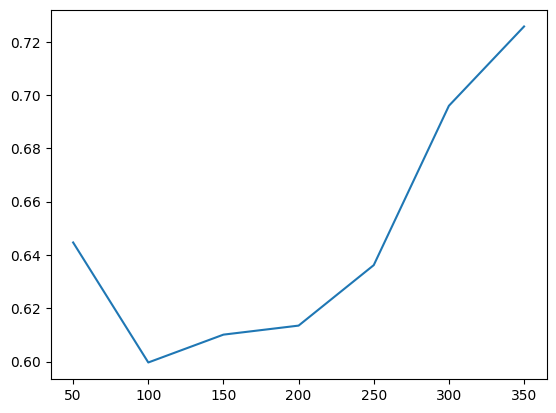

In [31]:
plt.plot(iters,val_loss[:len(iters)])

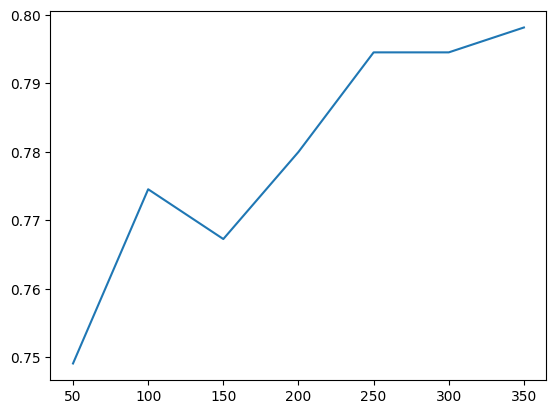

In [32]:
plt.plot(iters,val_accuracy[:len(iters)])

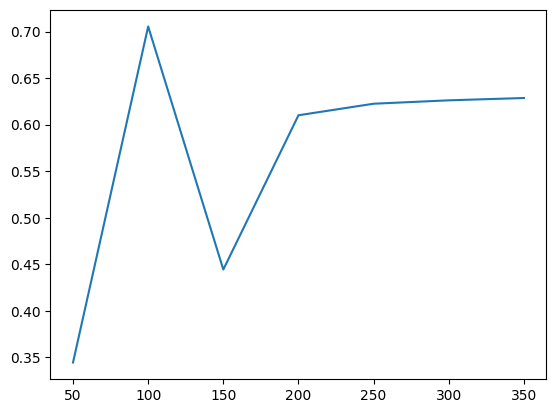

In [33]:
plt.plot(iters,val_precision[:len(iters)])

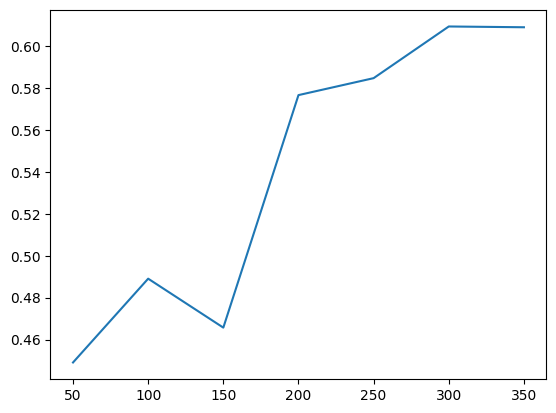

In [34]:
plt.plot(iters,val_recall[:len(iters)])

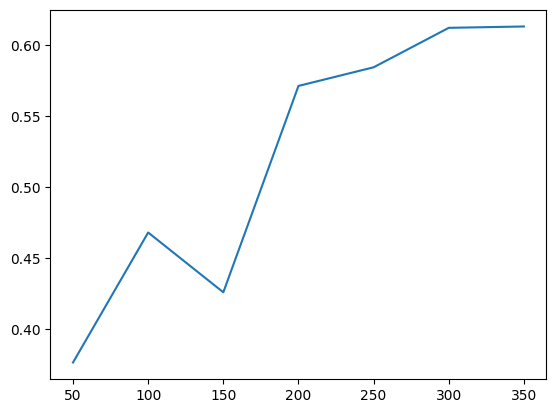

In [35]:
plt.plot(iters,val_f1[:len(iters)])

In [36]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

100%|██████████| 18/18 [00:08<00:00,  2.09it/s]


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.091532,0.971818,0.958446,0.968368,0.950330
val,0.725824,0.798182,0.612925,0.628669,0.608948
test,0.670603,0.814882,0.658754,0.666659,0.653865


In [37]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("mps")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [38]:
# Test with a an example text in Turkish
text = "double bottom."
# "Machine Learning itself is moving towards more and more automated"
predict(text)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:245.)
  nonzero_finite_vals = torch.masked_select(


(tensor([[0.7274, 0.0037, 0.0599, 0.2090]], device='mps:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(0, device='mps:0'),
 'positive')

In [39]:
predict('fire everyone')

(tensor([[0.3484, 0.0070, 0.6119, 0.0327]], device='mps:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(2, device='mps:0'),
 'neutral')

In [40]:
predict('on fire')

(tensor([[0.4780, 0.0132, 0.1869, 0.3218]], device='mps:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(0, device='mps:0'),
 'positive')

In [41]:
predict('downside potential')

(tensor([[0.0178, 0.0194, 0.0505, 0.9122]], device='mps:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(3, device='mps:0'),
 'negative')

In [42]:
predict('high growth')

(tensor([[0.9778, 0.0043, 0.0120, 0.0059]], device='mps:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(0, device='mps:0'),
 'positive')

In [43]:
predict('slow growth')

(tensor([[0.9412, 0.0039, 0.0460, 0.0088]], device='mps:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(0, device='mps:0'),
 'positive')

In [44]:
predict('increase in short interest')

(tensor([[0.7911, 0.0070, 0.1936, 0.0083]], device='mps:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(0, device='mps:0'),
 'positive')

In [45]:
predict('can anyone tell me?')

(tensor([[0.0253, 0.0139, 0.9425, 0.0184]], device='mps:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(2, device='mps:0'),
 'neutral')

In [46]:
predict('https://www')

(tensor([[0.0037, 0.9888, 0.0041, 0.0034]], device='mps:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(1, device='mps:0'),
 'spam')

## Save model for inference

In [47]:
model_path = "stocktwits-bert-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('stocktwits-bert-classification-model/tokenizer_config.json',
 'stocktwits-bert-classification-model/special_tokens_map.json',
 'stocktwits-bert-classification-model/vocab.txt',
 'stocktwits-bert-classification-model/added_tokens.json')

## Re-Load saved model for inference

In [48]:
model_path = "stocktwits-bert-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizer.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [49]:
nlp("revenue growth sluggish")

[{'label': 'positive', 'score': 0.6802113056182861}]

In [50]:
nlp("slow earnings.")

[{'label': 'negative', 'score': 0.5322777628898621}]

In [51]:
nlp("high profits.")

[{'label': 'positive', 'score': 0.9753327965736389}]

In [52]:
full_data = pd.read_csv('full_data.csv')
message_id = full_data.message_id.values
text_body = full_data.body.values
# 38000 and 47533 cause errors for some reason

In [53]:
custom_label2id = {}
custom_label2id['spam']=2
custom_label2id['negative']=-1
custom_label2id['positive']=1
custom_label2id['neutral']=0
labels = []
labels_numeric = []
for index, tweet in enumerate(text_body):
    if index==38000 or index==47533:
        labels.append('error')
        labels_numeric.append(99999)
    else:
        label = nlp(tweet)[0]['label']
        labels.append(label)
        labels_numeric.append(custom_label2id[label])
    if (index+1)%1000==0:
        print(index+1)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000


In [54]:
dic = {'message_id': message_id, 'body':text_body, 'label': labels, 'label_numeric':labels_numeric}
save_totxt = pd.DataFrame(dic)

In [55]:
save_totxt.to_csv('results/labelled_full_bert.csv')